# init

In [1]:
# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 

# to be able to use python files
import sys 
sys.path.append('pyfiles/')
import classes as cl
# This reloads external modules every time a cell is run
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2
import csv #for loading function

# input shape

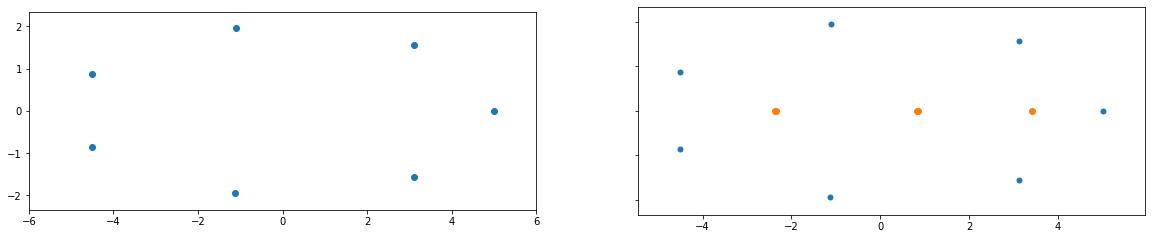

In [2]:
points = cl.ellipse_example(numpts = 7)

# turn points into simplices, add connecting edges, order under dist sq

[25.0, 12.17, 5.03, 21.01, 21.08, 5.06, 12.14]


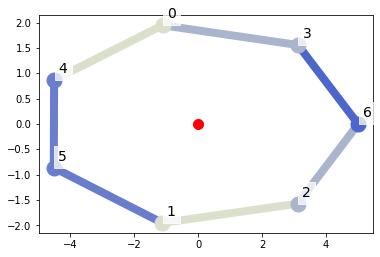

In [3]:
init_complex = cl.complex()
init_complex.init_verts(points)

# I don't remember if the deepcopy were to learn about 
# python linking things together, or if it served a later purpose
complexx = deepcopy(init_complex)
complexx.init_edges()
# complexx.plot()

# I don't remember why we need to deepcopy again. do we really?
# I also don't remember why it works to deepcopy an empty cplx
# is it getting the data from complexx, or initcomplex??
orderedcplx = deepcopy(cl.complex())

# the key point is the one we will take the squared dist from
orderedcplx.key_point = (0,0)
distlist = orderedcplx.find_sq_dist(init_complex)

# PERMUTE indices
orderedcplx.sort_inds(distlist)
# orderedcplx.print_inds()
# now, orderedcplx has a correct orderedindex for every vert
# edges still need to be indexed based on this ordering

# TODO: DECIDE ON RULE FOR THE BOUNDARY: INITIAL INPUT OR ORDERED
# we want to put them into the matrix in order but we'll change it later

orderedcplx.sort_edges()
orderedcplx.plot()
# print([v.index for v in orderedcplx.vertlist])

## Next we want to build the persistence matrix.
this gives a total order on verts and edges, first by function value, and then by dimension, and then by initial index

In [4]:
all_simplices = orderedcplx.vertlist + orderedcplx.edgelist
simplex_key = lambda simplex: (simplex.orderedindex, len(simplex.boundary), simplex.index)
all_simplices.sort(key=simplex_key)

for i in range(len(all_simplices)):
    all_simplices[i].columnvalue = i + 1

## build the boundary matrix and reduce it

NOTE: Matrix is for reduced homology, so it starts with the empty set in col 0.
also to note: we use one big matrix for edges and verts, so they are intermingled.


next we want to make a function that builds a np array from the ordered cplx. 
it will be a square matrix, with length nedges + nverts + 1 (because of empty simplex for reduced homology)
NOTE: WE DON'T ALLOW FOR TRIANGLES YET BUT EVENTUALLY SHOULD

simplices in filtration order across top and same order going down
child is going down and parent is across 
if child i in parent j, (i,j) row,column gets a 1
for all vert parents: they all get a 1 for empty set and 0 else

note from Teresa: we can separate the matrices into one each for verts, edges, triangles, 
... not sure if this is better in practice

In [16]:
mat = cl.bdmatrix()
mat.make_matrix(orderedcplx)
reduced = mat.reduce(display = False)

columns:  15  rows:  15


In [20]:
# here, index refers as usual to the very initial index a simplex has
# dim is the dim of column simplex, as in index

# dim for lows is ROW DIM
lowestones = {
    "col" : [],
    "row" : [],
    "dim" : [],
    "index" : []    
}

# dim here is COL DIM
zerocolumns = {
    "col" : [],
    "dim" : [],
    "index" : []    
}

##
# next: in reduced matrix, count number of 0-columns for each dim
# then count number of lowest ones for each dim
length = len(reduced[:][0])
# check that the first column is a 0 column
# (reduced homology means it should always be a 0 col)
for i in range(length):
    if reduced[length - i - 1][0] == 1:
        print("ERROR! this is supposed to be a zero column, but there is a 1 at row ", length - i -1)
        break
# if we didn't error out, we count the dummy column towards homology
zerocolumns["col"].append(0)
zerocolumns["dim"].append(-1)
zerocolumns["index"].append(0)

# next, for column j in the matrix, check from bottom for lowest ones. 
# if no ones are found, then it is a zero column.
# spits out row value for lowest one in a column
zerocol = True
for j in range(length):
    # we know it's a square matrix by construction 
    for i in range(length):
        # here we go backwards up the columns to search for lowest ones.
        if reduced[length - i - 1][j] == 1:
            # check what dimension it is
            # find simplex in all_simplices s.t. simplex.columnvalue = j
            for x in all_simplices: 
                # I think this is the only change we need to make.
                if x.columnvalue == j:
                    lowestones["col"].append(j)
                    lowestones["row"].append(length - i -1)
                    lowestones["index"].append(x.index)
                    # we subtract 2 because it is ROW dim not COL!!
                    # this one took f*cking forever to find
                    lowestones["dim"].append(len(x.boundary) - 2)
#                     print(x)
            zerocol = False
            break
    if zerocol:
        for x in all_simplices:
                if x.columnvalue == j:
                    zerocolumns["col"].append(j)
                    zerocolumns["dim"].append(len(x.boundary) - 1)
                    zerocolumns["index"].append(x.index)
#                     print(x)
    zerocol = True
    
print("Zero Columns:")
for key, value in zerocolumns.items():
    print(key, ":", value)
print("\nLowest Ones:")
for key, value in lowestones.items():
    print(key, ":", value)
    
# Betti_p = #zero_p - #low_p

betti_dummy = 0
betti_zero = 0
betti_one = 0

for x in zerocolumns["dim"]:
    if x == -1:
        betti_dummy += 1
    if x == 0:
        betti_zero += 1
    if x == 1:
        betti_one += 1
        
for x in lowestones["dim"]:
    if x == -1:
        betti_dummy -= 1
    if x == 0:
        betti_zero -= 1
    if x == 1:
        betti_one -= 1
print("dummy: ", betti_dummy, "\nzero: ", betti_zero, "\none:" ,betti_one)

Zero Columns:
col : [0, 2, 3, 5, 7, 9, 12, 14]
dim : [-1, 0, 0, 0, 0, 0, 0, 1]
index : [0, 5, 6, 1, 3, 4, 0, 6]

Lowest Ones:
col : [1, 4, 6, 8, 10, 11, 13]
row : [0, 3, 5, 7, 9, 2, 12]
dim : [-1, 0, 0, 0, 0, 0, 0]
index : [2, 5, 1, 2, 3, 4, 0]
dummy:  0 
zero:  0 
one: 1


## next: use ordering obtained sorting via distance func to make matrix

# misc

note

 if column is repr as set of indices, max yields lowest one
 max can (maybe) be re-keyed to return max wrt ie radius instead of index
 max(column, key=...), key as lambda funcion like for enumerate

 consider redoing matrices? 

In [8]:
[i*3 for i in range(5)]

[0, 3, 6, 9, 12]

In [9]:
{i**2 for i in range(-5,6)}

{0, 1, 4, 9, 16, 25}